# Classification of synthetic time series data
Following on from simulating data using SSA, we aim to classify the time series generated with an ML algorithm e.g, Support Vector Machine (SVM), and they need to be similar enough to be difficult to classify.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import simulate_two_telegraph_model_systems
from ssa_analysis import *
from ssa_classification import *
from models.MLP import MLP
from statsmodels.nonparametric.smoothers_lowess import lowess
%load_ext autoreload
%autoreload 2

SVM to classify the two different environments, ideally we'd like to make things difficult for them to distinguish

=== SVM (RBF Kernel) Classification Accuracy: 0.68 ===
=== Random Forest Accuracy: 0.68 ===


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== Logistic Regression Accuracy: 0.53 ===
=== Random Classifier Accuracy: 0.56 ===


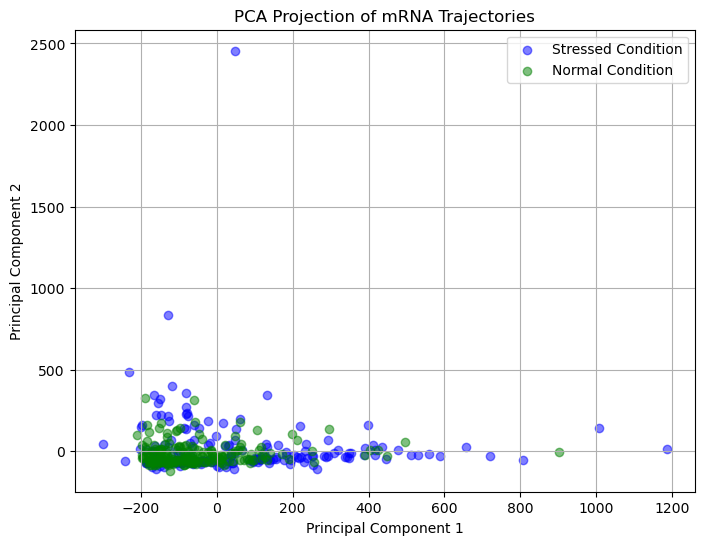

In [3]:
output_file = "data/mRNA_trajectories_mean_fixed.csv"
X_train, X_test, y_train, y_test = load_and_split_data(output_file)
svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
random_accuracy = random_classifier(y_test)
pca_plot(output_file)

Autocorrelation & Cross-correlation

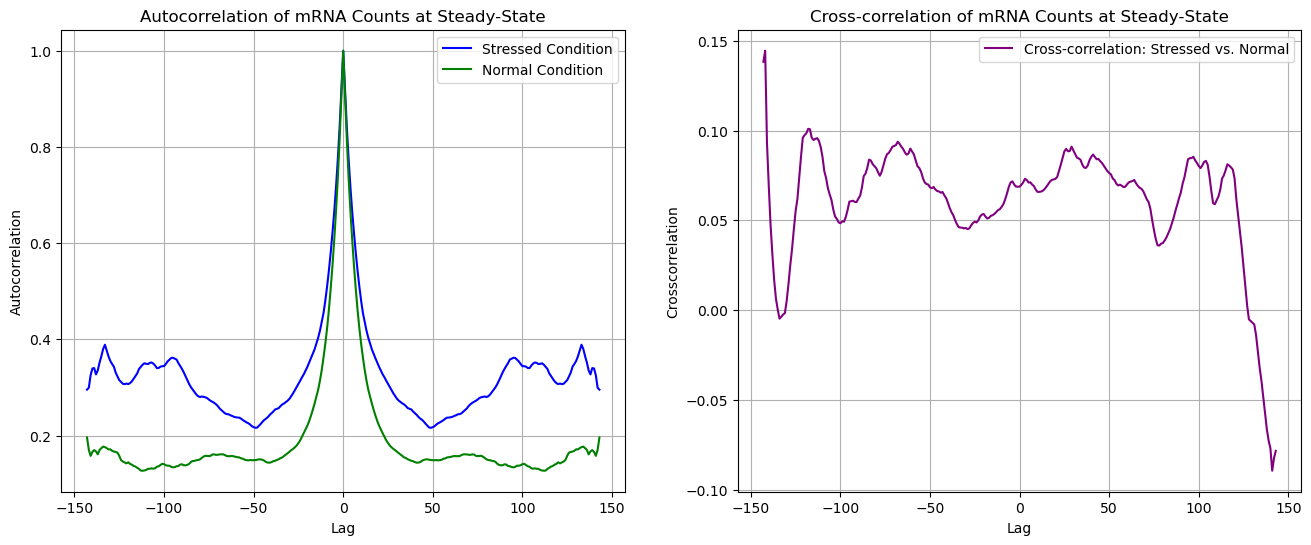

In [5]:
output_file = "data/mRNA_trajectories_mean_fixed.csv"
df_results = pd.read_csv(output_file)

# Define system parameters
mu_target = 10.0  

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Define degradation rates
d_stress = d_normal = 0.12

# Compute corresponding transcription rates (rho) using the given formula
rho_stress = (mu_target * d_stress * (sigma_u_stress + sigma_b_stress)) / sigma_b_stress
rho_normal = (mu_target * d_normal * (sigma_u_normal + sigma_b_normal)) / sigma_b_normal

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

plot_autocrosscorr(parameter_sets, stress_trajectories, normal_trajectories)

Change the variance ratio over a range, then plot Variance Ratio VS. Prediction Accuracy (SVM, Random Forest, Logistic Regression and Random Classifier)

<span style="color: red">**This will run for a while, so I ran this in a separate python script instead. The script and the data is stored in **var_v_accuracy_plot.py**</span>

<span style='color:red'>**DON'T RUN THIS IN THE NOTEBOOK.**</span>

In [ ]:
# Define system parameters
variance_target_normal = 1200.0
variance_ratios = np.arange(0.1, 3.0, 0.01)

# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition
d_stress = d_normal = 1 # Define degradation rates

'''
# Iterate over different variance ratios
for ratio in tqdm.tqdm(variance_ratios, desc="Running Variance Ratio Simulations"):
    variance_target_stress = ratio * variance_target_normal  # Adjust stress variance based on ratio

    # Compute transcription rates (rho) for both conditions
    rho_stress = - (sigma_b_stress + sigma_u_stress) * np.sqrt(d_stress + sigma_b_stress + sigma_u_stress) * (
        np.sqrt(sigma_b_stress) * np.sqrt(d_stress + sigma_b_stress + sigma_u_stress) -
        np.sqrt(sigma_b_stress * (sigma_b_stress + sigma_u_stress) + d_stress * (sigma_b_stress + 4 * variance_target_stress * sigma_u_stress))
    ) / (2 * np.sqrt(sigma_b_stress) * sigma_u_stress)

    rho_normal = - (sigma_b_normal + sigma_u_normal) * np.sqrt(d_normal + sigma_b_normal + sigma_u_normal) * (
        np.sqrt(sigma_b_normal) * np.sqrt(d_normal + sigma_b_normal + sigma_u_normal) -
        np.sqrt(sigma_b_normal * (sigma_b_normal + sigma_u_normal) + d_normal * (sigma_b_normal + 4 * variance_target_normal * sigma_u_normal))
    ) / (2 * np.sqrt(sigma_b_normal) * sigma_u_normal)

    # Update parameter sets
    parameter_sets = [
        {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
        {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
    ]

    # Set simulation parameters
    time_points = np.arange(0, 144.0, 1.0)  
    size = 200  
    # set the number of iterations to run for the simulation
    num_iterations = 10

    for i in range(num_iterations):
        # Run the simulation
        df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

        # Save dataset for ML classification
        output_dir = f"data/mRNA_trajectories_variance_{int(variance_target_stress)}_{int(variance_target_normal)}"
        os.makedirs(output_dir, exist_ok=True)

        output_file = f"{output_dir}/m_traj_{variance_target_stress}_{variance_target_normal}_{i}.csv"
        df_results.to_csv(output_file, index=False)

        # Extract mRNA trajectories
        stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  
        normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  

        # Statistical report
        stats = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

        # classifiers
        X_train, X_test, y_train, y_test = load_and_split_data(output_file)
        svm_accuracy = svm_classifier(X_train, X_test, y_train, y_test)
        rf_accuracy = random_forest_classifier(X_train, X_test, y_train, y_test)
        log_reg_accuracy = logistic_regression_classifier(X_train, X_test, y_train, y_test)
        random_accuracy = random_classifier(y_test)
        df_acc_results = pd.DataFrame({
            "Parameter Sets": parameter_sets,
            "Stats": stats,
            "Variance Ratio": ratio,
            "SVM Accuracy": svm_accuracy,
            "Random Forest Accuracy": rf_accuracy,
            "Logistic Regression Accuracy": log_reg_accuracy,
            "Random Classifier Accuracy": random_accuracy
        })

        # Save the accuracy results to a csv file
        if not os.path.isfile("data/accuracy_results.csv"):
            df_acc_results.to_csv("data/accuracy_results.csv", index=False)
        else:
            df_acc_results.to_csv("data/accuracy_results.csv", mode='a', header=False, index=False)
'''

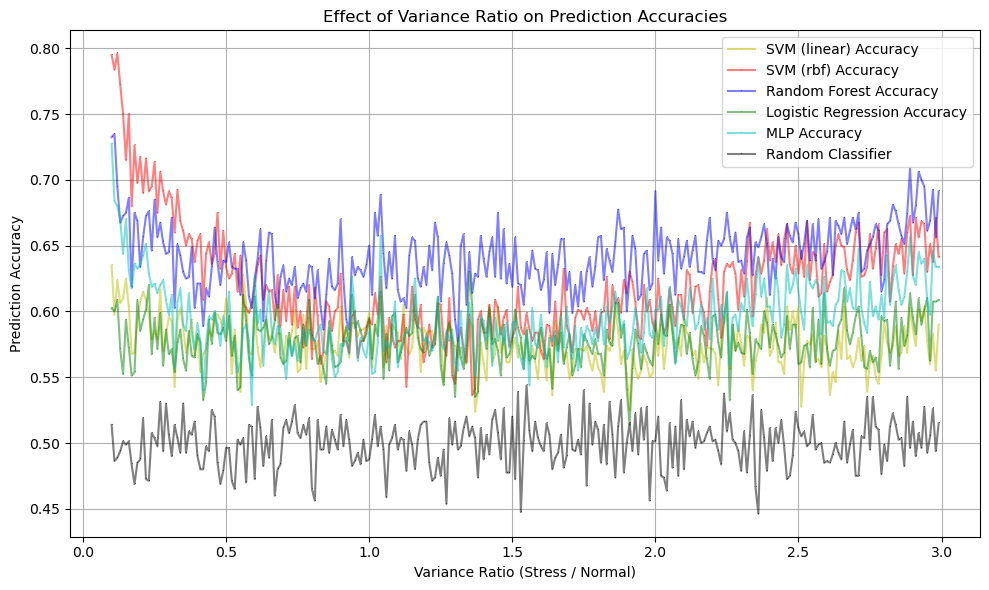

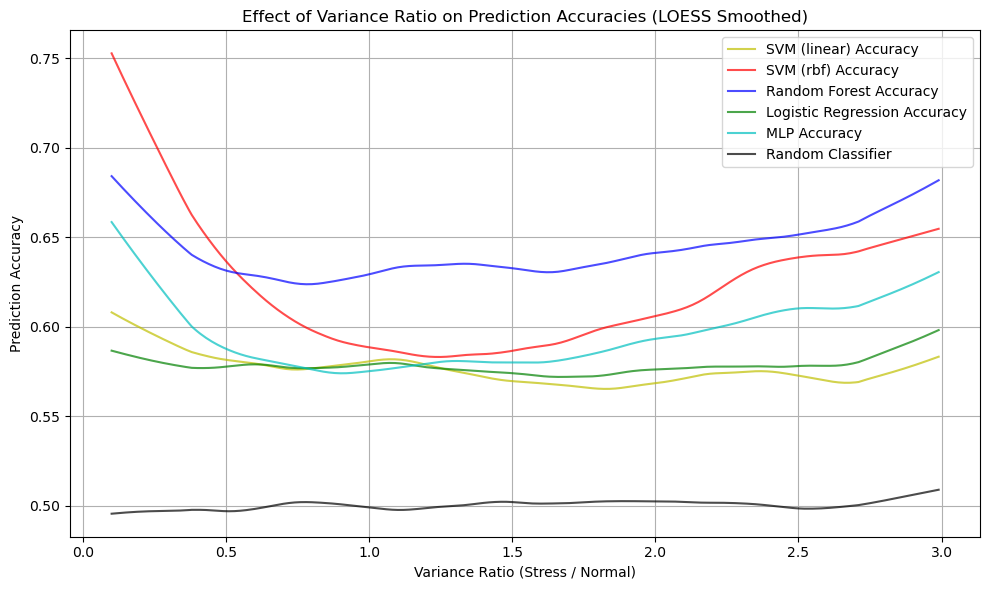

In [7]:
# Read in accuracy data
df_acc_results = pd.read_csv("data/accuracy_results_05_03_2025.csv")
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs SVM Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()

Benchmarking: keeping the mean constant whilst changing the variance

In [3]:
# Read in accuracy data
df_acc_results = pd.read_csv("data/accuracy_results_22_03_2025.csv")
df_acc_results.head()

,Parameter Sets,Stats,Variance Ratio,SVM (rbf) Accuracy,SVM (linear) Accuracy,Random Forest Accuracy,Logistic Regression Accuracy,MLP Accuracy,Random Classifier Accuracy
0,"[{'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 194...","({'Stressed Mean': 1.2875, 'Stressed Variance'...",0.1,0.8250,0.5500,0.6750,0.5375,0.6375,0.4750
1,"[{'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 194...","({'Stressed Mean': 0.8797388059701493, 'Stress...",0.1,0.7875,0.6500,0.7625,0.6250,0.7375,0.6125
2,"[{'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 194...","({'Stressed Mean': 1.2005223880597016, 'Stress...",0.1,0.8125,0.5875,0.7125,0.5875,0.7250,0.4750
3,"[{'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 194...","({'Stressed Mean': 0.9769029850746269, 'Stress...",0.1,0.8000,0.7125,0.7625,0.6750,0.7250,0.4625
4,"[{'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 194...","({'Stressed Mean': 1.2115298507462686, 'Stress...",0.1,0.8375,0.6375,0.7500,0.5500,0.7125,0.5375


In [4]:
# Extract the variance ratios and accuracies
variance_ratios_recorded = df_acc_results["Variance Ratio"].unique()
linear_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (linear) Accuracy"].mean()
rbf_svm_accuracy = df_acc_results.groupby("Variance Ratio")["SVM (rbf) Accuracy"].mean()
rf_accuracy = df_acc_results.groupby("Variance Ratio")["Random Forest Accuracy"].mean()
log_reg_accuracy = df_acc_results.groupby("Variance Ratio")["Logistic Regression Accuracy"].mean()
mlp_accuracy = df_acc_results.groupby("Variance Ratio")["MLP Accuracy"].mean()
random_accuracy = df_acc_results.groupby("Variance Ratio")["Random Classifier Accuracy"].mean()

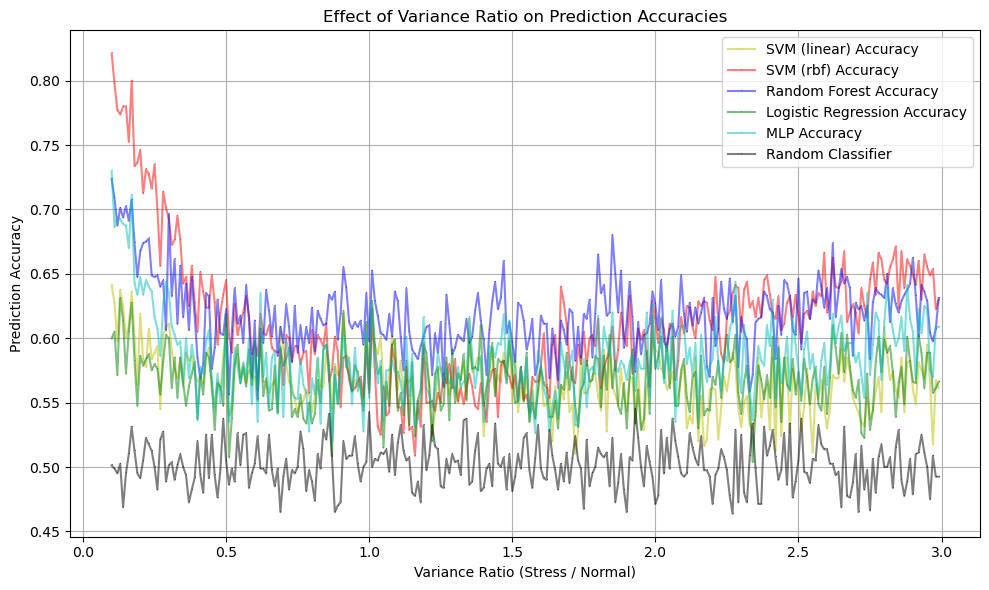

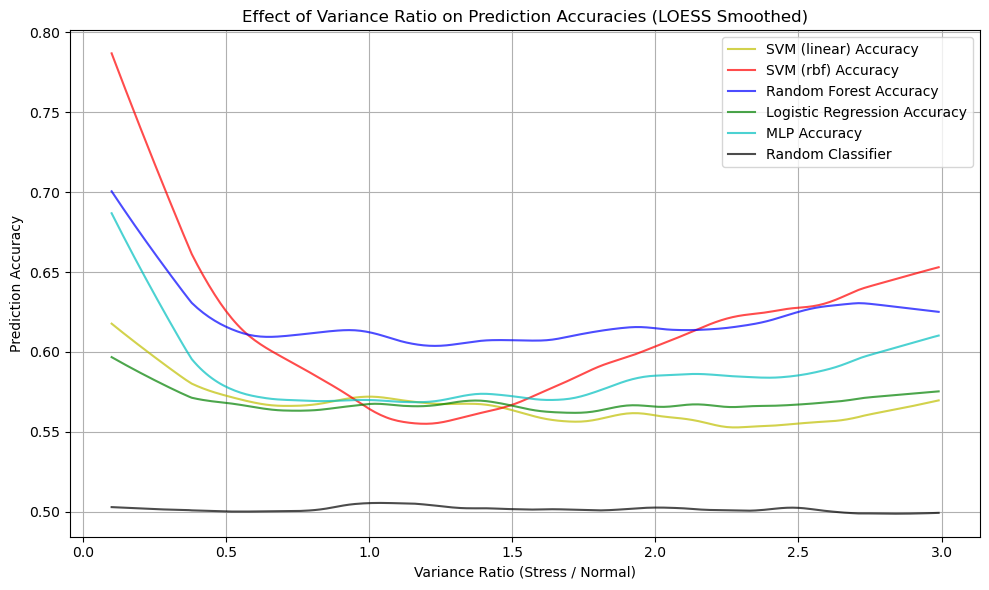

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.figure(figsize=(10, 6))
# Plot Variance Ratio vs SVM Accuracy
plt.plot(variance_ratios_recorded, linear_svm_accuracy, marker=',', linestyle='-', color='y', label="SVM (linear) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rbf_svm_accuracy, marker=',', linestyle='-', color='r', label="SVM (rbf) Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, rf_accuracy, marker=',', linestyle='-', color='b', label="Random Forest Accuracy", alpha= 0.5)
plt.plot(variance_ratios_recorded, log_reg_accuracy, marker=',', linestyle='-', color='g', label="Logistic Regression Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, mlp_accuracy, marker=',', linestyle='-', color='c', label="MLP Accuracy", alpha=0.5)
plt.plot(variance_ratios_recorded, random_accuracy, marker=',', linestyle='-', color='k', label="Random Classifier", alpha=0.5)
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy.png")
plt.show()

# Apply LOESS smoothing to the data
linear_svm_loess = lowess(linear_svm_accuracy, variance_ratios_recorded, frac=0.2)
rbf_svm_loess = lowess(rbf_svm_accuracy, variance_ratios_recorded, frac=0.2)
rf_loess = lowess(rf_accuracy, variance_ratios_recorded, frac=0.2)
log_reg_loess = lowess(log_reg_accuracy, variance_ratios_recorded, frac=0.2)
mlp_loess = lowess(mlp_accuracy, variance_ratios_recorded, frac=0.2)
random_loess = lowess(random_accuracy, variance_ratios_recorded, frac=0.2)

# Plot the LOESS smoothed data
plt.figure(figsize=(10, 6))
plt.plot(linear_svm_loess[:, 0], linear_svm_loess[:, 1], linestyle='-', color='y', alpha=0.7, label="SVM (linear) Accuracy")
plt.plot(rbf_svm_loess[:, 0], rbf_svm_loess[:, 1], linestyle='-', color='r', alpha=0.7, label="SVM (rbf) Accuracy")
plt.plot(rf_loess[:, 0], rf_loess[:, 1], linestyle='-', color='b', alpha=0.7, label="Random Forest Accuracy")
plt.plot(log_reg_loess[:, 0], log_reg_loess[:, 1], linestyle='-', color='g', alpha=0.7, label="Logistic Regression Accuracy")
plt.plot(mlp_loess[:, 0], mlp_loess[:, 1], linestyle='-', color='c', alpha=0.7, label="MLP Accuracy")
plt.plot(random_loess[:, 0], random_loess[:, 1], linestyle='-', color='k', alpha=0.7, label="Random Classifier")
plt.xlabel("Variance Ratio (Stress / Normal)")
plt.ylabel("Prediction Accuracy")
plt.title("Effect of Variance Ratio on Prediction Accuracies (LOESS Smoothed)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figs/variance_ratio_vs_accuracy_loess.png")
plt.show()